In [7]:

# 1. SETUP AND IMPORTS
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import DistilBertTokenizer
from tqdm.cli import tqdm  # Force Command Line Interface (text) version
# Import our updated project modules
from data.processing import load_and_prepare_data, create_book_pairs, get_metadata_features, get_text_features
from model.encoders import MLPEncoder, BERTEncoder, CNNEncoder, HybridEncoder # CNN and Hybrid can be added later
from model.siamese import SiameseModel
from train.losses import contrastive_loss
from evaluate.plots import plot_roc_curves, plot_embeddings



In [ ]:
# --- Cell: Configuration (Corrected) ---

# Global variables and hyperparameters
BATCH_SIZE = 64
EPOCHS = 2                 # Set to 1 for quick testing, 5-10 for final results
EMBEDDING_DIM = 128
MAX_TITLE_LENGTH = 25
PAIR_SAMPLE_SIZE = 2000

# Learning Rates for each model type
MLP_LEARNING_RATE = 1e-3
CNN_LEARNING_RATE = 1e-3  # Same as MLP, but explicitly defined for clarity
BERT_LEARNING_RATE = 5e-5 # Lower learning rate is crucial for fine-tuning transformers

# Set the correct path
DATA_PATH = "data/kaggle_data/" 

print("Configuration set with specific learning rates for each model.")

Configuration set with specific learning rates for each model.


In [9]:

# ## 2. Data Loading and Pair Creation


# Load and process the new dataset
reviews_df, books_df = load_and_prepare_data(data_path=DATA_PATH)

# Create book pairs using the reviews data
pairs_df = create_book_pairs(reviews_df, min_ratings=5, sample_size=PAIR_SAMPLE_SIZE)

# Filter out pairs where one of the books might not have metadata
valid_book_ids = set(books_df['book_id'])
pairs_df = pairs_df[pairs_df['book_a'].isin(valid_book_ids) & pairs_df['book_b'].isin(valid_book_ids)]

print(f"Total pairs for training/testing: {len(pairs_df)}")
display(pairs_df.head())


Successfully loaded and merged data.
Found 2438213 reviews and 216023 unique books with metadata.
Generating positive pairs...


100%|██████████| 65285/65285 [00:14<00:00, 4374.58it/s] 


Sampling down to 200 positive pairs...
Generating negative pairs...


100%|██████████| 200/200 [00:00<00:00, 34475.62it/s]


Creating final DataFrame...


Total pairs for training/testing: 400


,book_a,book_b,label
0,0849382718,140101397X,0
1,B0006FF1C6,B0007FGOPI,1
2,0738802832,B0006AL8CI,0
3,0801011965,1575001292,1
4,044020853X,B0007E8P9M,0


In [10]:

# ## 3. Feature Engineering


print("Preparing metadata features...")
metadata_features = get_metadata_features(books_df)

print("Preparing text features...")
text_features = get_text_features(books_df)

# --- NEW LINE ADDED HERE ---
# We need the tokenizer's vocabulary size for the CNN/Hybrid embedding layers
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
vocab_size = tokenizer.vocab_size
print(f"Tokenizer loaded. Vocabulary size: {vocab_size}")

def prepare_data_for_model(df, metadata_map, text_map):
    """Pre-generates all data into NumPy arrays for maximum performance."""
    book_a_meta = np.array([metadata_map.loc[id].values for id in df['book_a']])
    book_b_meta = np.array([metadata_map.loc[id].values for id in df['book_b']])
    
    titles_a = text_map.loc[df['book_a']]['title'].tolist()
    titles_b = text_map.loc[df['book_b']]['title'].tolist()
    tokens_a = tokenizer(titles_a, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')
    tokens_b = tokenizer(titles_b, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')
    
    return {
        "mlp_input": [book_a_meta.astype('float32'), book_b_meta.astype('float32')],
        "bert_input": [
            {'input_ids': tokens_a['input_ids'], 'attention_mask': tokens_a['attention_mask']},
            {'input_ids': tokens_b['input_ids'], 'attention_mask': tokens_b['attention_mask']}
        ],
        "cnn_input": [tokens_a['input_ids'], tokens_b['input_ids']],
        "labels": df['label'].values
    }

train_df, test_df = train_test_split(pairs_df, test_size=0.2, random_state=42)

print("\nPreparing training data into NumPy arrays (this may take a minute)...")
train_data = prepare_data_for_model(train_df, metadata_features, text_features)

print("Preparing validation data into NumPy arrays...")
val_data = prepare_data_for_model(test_df, metadata_features, text_features)

print("Data preparation for TensorFlow is complete.")

Preparing metadata features...
Preparing text features...
Tokenizer loaded. Vocabulary size: 30522

Preparing training data into NumPy arrays (this may take a minute)...
Preparing validation data into NumPy arrays...
Data preparation for TensorFlow is complete.


In [11]:

# ## 4. Preparing Data for TensorFlow (New, High-Performance Method)
#
# Instead of a slow Python generator, we will prepare all data in memory as NumPy arrays.
# This is much more efficient and the standard way to do it for datasets that fit in memory.
'''
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(pairs_df, test_size=0.2, random_state=42)

def prepare_data_for_model(df, metadata_map, text_map):
    """
    Pre-generates all data into NumPy arrays for maximum performance.
    """
    # Metadata for MLP
    book_a_meta = np.array([metadata_map.loc[id].values for id in df['book_a']])
    book_b_meta = np.array([metadata_map.loc[id].values for id in df['book_b']])

    # Text for BERT/CNN (Tokenization)
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    titles_a = text_map.loc[df['book_a']]['title'].tolist()
    titles_b = text_map.loc[df['book_b']]['title'].tolist()

    tokens_a = tokenizer(titles_a, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')
    tokens_b = tokenizer(titles_b, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')

    # Labels
    labels = df['label'].values

    return {
        "mlp_input": [book_a_meta, book_b_meta],
        "bert_input": [
            {'input_ids': tokens_a['input_ids'], 'attention_mask': tokens_a['attention_mask']},
            {'input_ids': tokens_b['input_ids'], 'attention_mask': tokens_b['attention_mask']}
        ],
        "labels": labels
    }

print("Preparing training data into NumPy arrays...")
train_data = prepare_data_for_model(train_df, metadata_features, text_features)

print("Preparing validation data into NumPy arrays...")
val_data = prepare_data_for_model(test_df, metadata_features, text_features)
'''
experiments = {}

In [12]:
# --- file: notebooks/experiments.ipynb ---

# --- Experiment 4: Hybrid (MLP + CNN) - Complete ---
print("\n--- Starting Hybrid Experiment ---")

# 1. Define the Hybrid Encoder Model (This part is correct)
hybrid_encoder = HybridEncoder(
    metadata_shape=(metadata_features.shape[1],), 
    max_length=MAX_TITLE_LENGTH, 
    vocab_size=vocab_size, 
    embedding_dim=EMBEDDING_DIM
)

# 2. Wrap it in the Siamese Model (This part is correct)
hybrid_siamese = SiameseModel(hybrid_encoder)
hybrid_siamese.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=MLP_LEARNING_RATE), 
    loss=contrastive_loss
)

# 3. Create the Data Pipeline (This part is correct)
#    This correctly groups the four input arrays for the model.
train_ds_hybrid = tf.data.Dataset.from_tensor_slices((
    (
        (train_data['mlp_input'][0], train_data['cnn_input'][0]), # Input for Book A (meta, text)
        (train_data['mlp_input'][1], train_data['cnn_input'][1])  # Input for Book B (meta, text)
    ),
    train_data['labels']
)).shuffle(1024).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

val_ds_hybrid = tf.data.Dataset.from_tensor_slices((
    (
        (val_data['mlp_input'][0], val_data['cnn_input'][0]), 
        (val_data['mlp_input'][1], val_data['cnn_input'][1])
    ),
    val_data['labels']
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# 4. Train the Model (This is the missing part)
#    This is where the actual training happens.
print("Starting Hybrid model training...")
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE
start_time = time.time()

history_hybrid = hybrid_siamese.fit(
    train_ds_hybrid, 
    epochs=EPOCHS, 
    steps_per_epoch=steps_per_epoch, 
    validation_data=val_ds_hybrid, 
    validation_steps=validation_steps
)
hybrid_time = time.time() - start_time


# 5. Evaluate the Model and Store the Results (This is the final part)
print("Evaluating Hybrid model...")
y_pred_hybrid = hybrid_siamese.predict(val_ds_hybrid, steps=validation_steps)
y_true_hybrid = val_data['labels'][:len(y_pred_hybrid)]

# Add the results to our master dictionary for final comparison
experiments['Hybrid'] = {
    'model': hybrid_siamese, 
    'y_pred': y_pred_hybrid, 
    'y_true': y_true_hybrid, 
    'time': hybrid_time, 
    'auc': roc_auc_score(y_true_hybrid, 1 - y_pred_hybrid)
}
print(f"Hybrid AUC: {experiments['Hybrid']['auc']:.4f}, Time: {hybrid_time:.2f}s")


--- Starting Hybrid Experiment ---
Starting Hybrid model training...
Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.3510 - val_loss: 0.3165
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2441 - val_loss: 0.3186
Evaluating Hybrid model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Hybrid AUC: 0.3773, Time: 2.46s


In [13]:
# --- file: notebooks/experiments.ipynb ---

# --- Experiment 4: Hybrid (MLP + CNN) - Complete ---
print("\n--- Starting Hybrid Experiment ---")

# 1. Define the Hybrid Encoder Model (This part is correct)
hybrid_encoder = HybridEncoder(
    metadata_shape=(metadata_features.shape[1],), 
    max_length=MAX_TITLE_LENGTH, 
    vocab_size=vocab_size, 
    embedding_dim=EMBEDDING_DIM
)

# 2. Wrap it in the Siamese Model (This part is correct)
hybrid_siamese = SiameseModel(hybrid_encoder)
hybrid_siamese.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=MLP_LEARNING_RATE), 
    loss=contrastive_loss
)

# 3. Create the Data Pipeline (This part is correct)
#    This correctly groups the four input arrays for the model.
train_ds_hybrid = tf.data.Dataset.from_tensor_slices((
    (
        (train_data['mlp_input'][0], train_data['cnn_input'][0]), # Input for Book A (meta, text)
        (train_data['mlp_input'][1], train_data['cnn_input'][1])  # Input for Book B (meta, text)
    ),
    train_data['labels']
)).shuffle(1024).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

val_ds_hybrid = tf.data.Dataset.from_tensor_slices((
    (
        (val_data['mlp_input'][0], val_data['cnn_input'][0]), 
        (val_data['mlp_input'][1], val_data['cnn_input'][1])
    ),
    val_data['labels']
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# 4. Train the Model (This is the missing part)
#    This is where the actual training happens.
print("Starting Hybrid model training...")
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE
start_time = time.time()

history_hybrid = hybrid_siamese.fit(
    train_ds_hybrid, 
    epochs=EPOCHS, 
    steps_per_epoch=steps_per_epoch, 
    validation_data=val_ds_hybrid, 
    validation_steps=validation_steps
)
hybrid_time = time.time() - start_time



--- Starting Hybrid Experiment ---
Starting Hybrid model training...
Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.3502 - val_loss: 0.3073
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2361 - val_loss: 0.3043


In [14]:


# 5. Evaluate the Model and Store the Results (This is the final part)
print("Evaluating Hybrid model...")
y_pred_hybrid = hybrid_siamese.predict(val_ds_hybrid, steps=validation_steps)
y_true_hybrid = val_data['labels'][:len(y_pred_hybrid)]

# Add the results to our master dictionary for final comparison
experiments['Hybrid'] = {
    'model': hybrid_siamese, 
    'y_pred': y_pred_hybrid, 
    'y_true': y_true_hybrid, 
    'time': hybrid_time, 
    'auc': roc_auc_score(y_true_hybrid, 1 - y_pred_hybrid)
}
print(f"Hybrid AUC: {experiments['Hybrid']['auc']:.4f}, Time: {hybrid_time:.2f}s")

Evaluating Hybrid model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Hybrid AUC: 0.3881, Time: 9.16s


In [15]:
# --- Experiment 4: Hybrid (MLP + CNN) ---
print("\n--- Starting Hybrid Experiment ---")

# The Hybrid model requires a dataset with two inputs per item
train_ds_hybrid = tf.data.Dataset.from_tensor_slices((
    ((train_data['mlp_input'][0], train_data['cnn_input'][0]), # Input A (metadata, text)
     (train_data['mlp_input'][1], train_data['cnn_input'][1])), # Input B (metadata, text)
    train_data['labels'] # Labels
)).shuffle(1024).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

val_ds_hybrid = tf.data.Dataset.from_tensor_slices((
    ((val_data['mlp_input'][0], val_data['cnn_input'][0]), 
     (val_data['mlp_input'][1], val_data['cnn_input'][1])),
    val_data['labels']
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

hybrid_encoder = HybridEncoder(metadata_shape=(metadata_features.shape[1],), max_length=MAX_TITLE_LENGTH, vocab_size=vocab_size, embedding_dim=EMBEDDING_DIM)
hybrid_siamese = SiameseModel(hybrid_encoder)
hybrid_siamese.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=MLP_LEARNING_RATE), loss=contrastive_loss)



--- Starting Hybrid Experiment ---


In [16]:

print("Starting Hybrid model training...")
start_time = time.time()
history_hybrid = hybrid_siamese.fit(train_ds_hybrid, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, validation_data=val_ds_hybrid, validation_steps=validation_steps)
hybrid_time = time.time() - start_time

print("Evaluating Hybrid model...")
y_pred_hybrid = hybrid_siamese.predict(val_ds_hybrid, steps=validation_steps)
y_true_hybrid = val_data['labels'][:len(y_pred_hybrid)]
experiments['Hybrid'] = {'model': hybrid_siamese, 'y_pred': y_pred_hybrid, 'y_true': y_true_hybrid, 'time': hybrid_time, 'auc': roc_auc_score(y_true_hybrid, 1 - y_pred_hybrid)}
print(f"Hybrid AUC: {experiments['Hybrid']['auc']:.4f}, Time: {hybrid_time:.2f}s")

Starting Hybrid model training...
Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.3621 - val_loss: 0.3033
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2277 - val_loss: 0.2984
Evaluating Hybrid model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Hybrid AUC: 0.4291, Time: 1.45s


In [17]:
# --- Cell: Experiment 3: CNN (Corrected) ---
print("\n--- Starting CNN Experiment ---")

# The CNN encoder only needs the token IDs, not the attention mask
train_ds_cnn = tf.data.Dataset.from_tensor_slices(((train_data['cnn_input'][0], train_data['cnn_input'][1]), train_data['labels'])).shuffle(1024).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
val_ds_cnn = tf.data.Dataset.from_tensor_slices(((val_data['cnn_input'][0], val_data['cnn_input'][1]), val_data['labels'])).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

cnn_encoder = CNNEncoder(max_length=MAX_TITLE_LENGTH, vocab_size=vocab_size, embedding_dim=EMBEDDING_DIM)
cnn_siamese = SiameseModel(cnn_encoder)

# --- THIS LINE IS CORRECTED ---
# It now uses the correct variable name defined in the configuration cell.
cnn_siamese.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CNN_LEARNING_RATE), loss=contrastive_loss)

# (The rest of the cell is the same)
print("Starting CNN model training...")
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE
start_time = time.time()
history_cnn = cnn_siamese.fit(train_ds_cnn, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, validation_data=val_ds_cnn, validation_steps=validation_steps)
cnn_time = time.time() - start_time

print("Evaluating CNN model...")
y_pred_cnn = cnn_siamese.predict(val_ds_cnn, steps=validation_steps)
y_true_cnn = val_data['labels'][:len(y_pred_cnn)]
experiments['CNN'] = {'model': cnn_siamese, 'y_pred': y_pred_cnn, 'y_true': y_true_cnn, 'time': cnn_time, 'auc': roc_auc_score(y_true_cnn, 1 - y_pred_cnn)}
print(f"CNN AUC: {experiments['CNN']['auc']:.4f}, Time: {cnn_time:.2f}s")


--- Starting CNN Experiment ---
Starting CNN model training...
Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.3335 - val_loss: 0.3021
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1916 - val_loss: 0.2924
Evaluating CNN model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
CNN AUC: 0.3910, Time: 1.44s


In [18]:
# --- file: notebooks/experiments.ipynb ---

# --- Experiment 2: BERT (Using a Subclassed Encoder) ---

print("\n--- Starting BERT Experiment ---")

# 1. Define the model by creating an INSTANCE of our new class.
#    No max_length is needed here as the model is not symbolic.
bert_encoder = BERTEncoder(embedding_dim=EMBEDDING_DIM)
bert_siamese = SiameseModel(bert_encoder)
bert_siamese.compile(optimizer=Adam(5e-5), loss=contrastive_loss) # Lower LR for fine-tuning
# 2. The data pipeline is already correct and doesn't need to be changed.
train_ds_bert = tf.data.Dataset.from_tensor_slices((
    (train_data['bert_input'][0], train_data['bert_input'][1]),
    train_data['labels']
)).shuffle(1024).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

val_ds_bert = tf.data.Dataset.from_tensor_slices((
    (val_data['bert_input'][0], val_data['bert_input'][1]),
    val_data['labels']
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 3. Calculate steps for model.fit()
steps_per_epoch_bert = len(train_df) // BATCH_SIZE
validation_steps_bert = len(test_df) // BATCH_SIZE



--- Starting BERT Experiment ---



TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was tr

In [19]:

# 4. Fit the model
print("Starting BERT model training...")
start_time = time.time()
history_bert = bert_siamese.fit(
    train_ds_bert,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch_bert,
    validation_data=val_ds_bert,
    validation_steps=validation_steps_bert
)
bert_time = time.time() - start_time


Starting BERT model training...
Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 2.0028 - val_loss: 1.8554
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 1.9039 - val_loss: 1.6938


In [20]:

# 5. Evaluation
print("Evaluating BERT model...")
y_pred_bert = bert_siamese.predict(val_ds_bert, steps=validation_steps_bert)
y_true_bert = val_data['labels'][:len(y_pred_bert)]

experiments['BERT'] = {
    'model': bert_siamese,
    'y_pred': y_pred_bert,
    'y_true': y_true_bert,
    'time': bert_time,
    'auc': roc_auc_score(y_true_bert, 1 - y_pred_bert)
}
print(f"BERT AUC: {experiments['BERT']['auc']:.4f}, Time: {bert_time:.2f}s")

Evaluating BERT model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
BERT AUC: 0.6676, Time: 28.91s


In [21]:
 
# ## 5. Training and Evaluation Loop
 
#EPOCHS = 3


# --- Experiment 1: MLP ---
print("\n--- Starting MLP Experiment ---")

# Create the optimized tf.data.Dataset
train_ds_mlp = tf.data.Dataset.from_tensor_slices((
    (train_data['mlp_input'][0], train_data['mlp_input'][1]), 
    train_data['labels']
)).shuffle(1024).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

val_ds_mlp = tf.data.Dataset.from_tensor_slices((
    (val_data['mlp_input'][0], val_data['mlp_input'][1]),
    val_data['labels']
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Define the model
mlp_input_shape = (metadata_features.shape[1],)
mlp_encoder = MLPEncoder(input_shape=mlp_input_shape, embedding_dim=EMBEDDING_DIM)
mlp_siamese = SiameseModel(mlp_encoder)
mlp_siamese.compile(optimizer=Adam(0.001), loss=contrastive_loss)

# Calculate steps_per_epoch
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE

start_time = time.time()
history_mlp = mlp_siamese.fit(
    train_ds_mlp, 
    epochs=EPOCHS, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds_mlp,
    validation_steps=validation_steps
)
mlp_time = time.time() - start_time

# --- Evaluation ---
y_pred_mlp = mlp_siamese.predict(val_ds_mlp, steps=validation_steps)
y_true_mlp = val_data['labels'][:len(y_pred_mlp)] # Ensure labels match prediction size

experiments['MLP'] = {
    'model': mlp_siamese,
    'y_pred': y_pred_mlp,
    'y_true': y_true_mlp,
    'time': mlp_time,
    'auc': roc_auc_score(y_true_mlp, 1 - y_pred_mlp)
}
print(f"MLP AUC: {experiments['MLP']['auc']:.4f}, Time: {mlp_time:.2f}s")




--- Starting MLP Experiment ---
Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4738 - val_loss: 0.4087
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4627 - val_loss: 0.3984
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
MLP AUC: 0.4682, Time: 0.97s



--- Final Results Summary ---


,Architecture,ROC-AUC,Training Time (s)
0,BERT,0.667644,28.9
1,MLP,0.468231,1.0
2,Hybrid,0.429130,1.4
3,CNN,0.391007,1.4



--- Generating ROC Curves ---


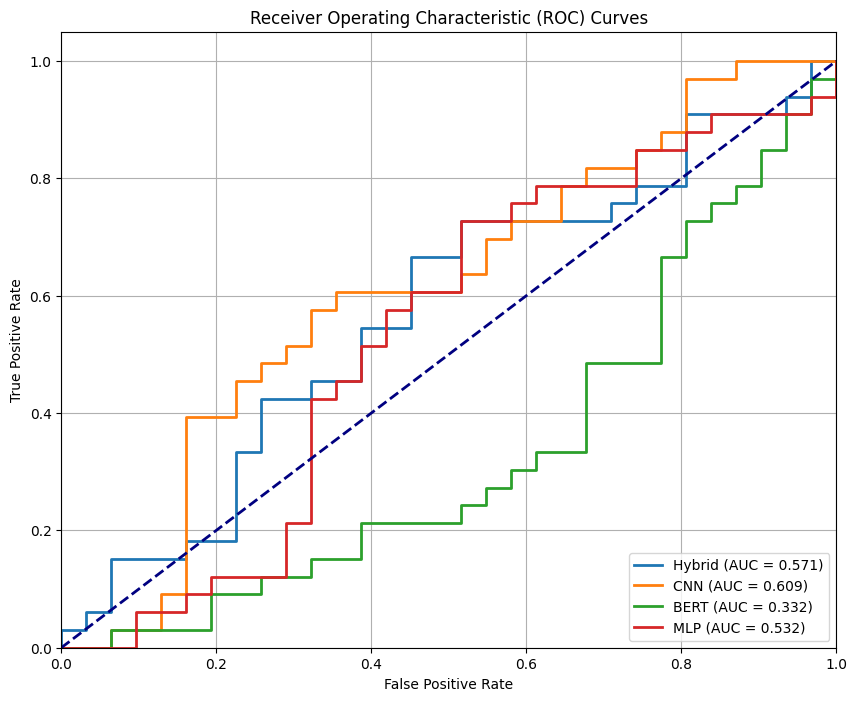


--- Generating Embedding Visualization for BERT Encoder ---
Generating embeddings for visualization...
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 319ms/step
Running UMAP dimensionality reduction...


c:\Users\premy\Documents\uni\raml\Recc\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


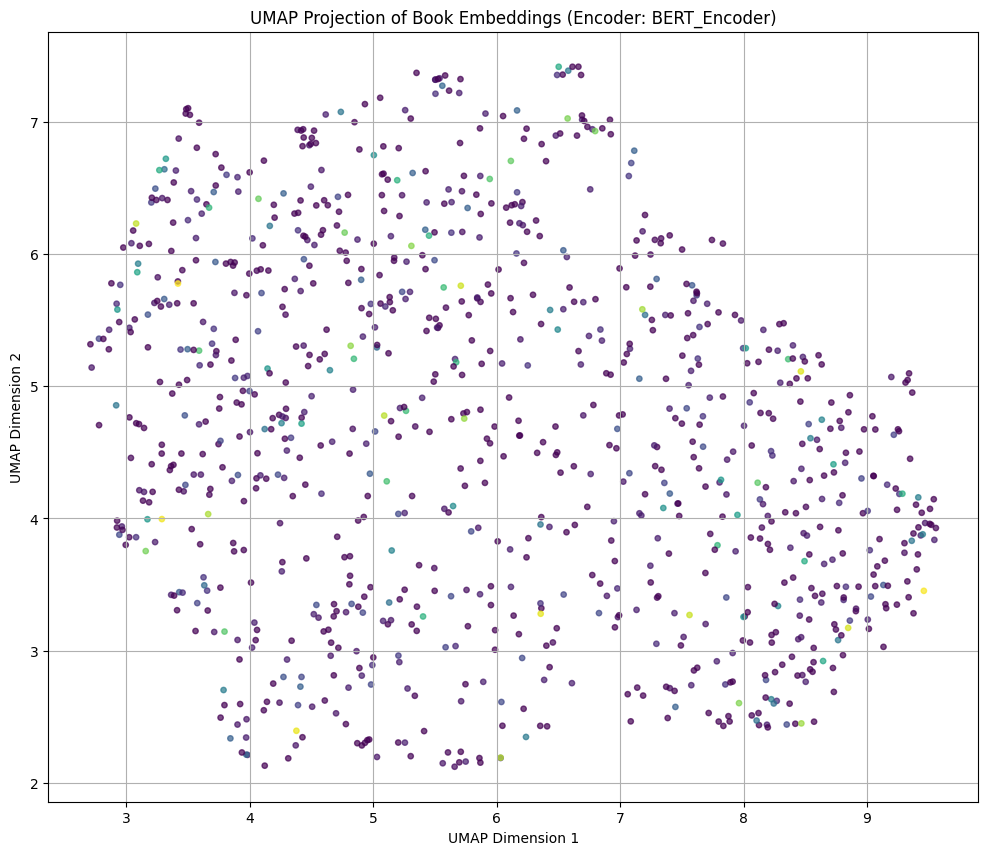

In [23]:
# --- file: notebooks/experiments.ipynb ---

# --- Cell: Final Results and Visualization (Corrected) ---

# ================================================
# 1. Quantitative Analysis: Summary Table
# ================================================
summary_df = pd.DataFrame([
    {
        'Architecture': name,
        'ROC-AUC': result['auc'],
        'Training Time (s)': round(result['time'], 1)
    } 
    for name, result in experiments.items()
])
print("\n--- Final Results Summary ---")
display(summary_df.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True))


# ================================================
# 2. Visual Analysis: ROC Curves
# ================================================
print("\n--- Generating ROC Curves ---")
plot_roc_curves(experiments)


# ================================================
# 3. Visual Analysis: Embedding Space Quality
# ================================================
print("\n--- Generating Embedding Visualization for BERT Encoder ---")

# a. Create a random sample of 1000 books to plot
sample_book_ids = np.random.choice(text_features.index, 1000, replace=False)
sample_titles = text_features.loc[sample_book_ids]['title'].tolist()

# b. Get the real categories for these books to use for coloring
try:
    # Look up the categories from the main books_df
    sample_categories_df = books_df[books_df['book_id'].isin(sample_book_ids)]
    # Extract the first category from the 'categories' string (e.g., "'Fiction'")
    sample_labels_text = sample_categories_df['categories'].str.extract(r'\'(\w+)\'').fillna('Unknown').iloc[:, 0]
    
    # --- THIS IS THE FIX ---
    # Convert the text labels (e.g., 'Fiction') into numerical codes for plotting.
    # `pd.factorize` returns both the numeric codes and the unique text labels.
    category_codes, unique_categories = pd.factorize(sample_labels_text)

except Exception as e:
    print(f"Could not extract real categories due to error: {e}. Using random labels for coloring.")
    category_codes = np.random.randint(0, 10, size=1000) # Fallback to random numbers
    unique_categories = None

# c. Tokenize the sampled titles for the BERT encoder
tokenized_samples = tokenizer(sample_titles, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')
bert_input_data = {'input_ids': tokenized_samples['input_ids'], 'attention_mask': tokenized_samples['attention_mask']}

# d. Call the plotting function with the PREPARED data
plot_embeddings(
    encoder=experiments['BERT']['model'].encoder, # The trained encoder
    data=bert_input_data,                         # The tokenized input data
    labels=category_codes                         # The NUMERICAL category codes for coloring
)

In [ ]:
# --- Plotting Training & Validation Loss ---

from matplotlib import pyplot as plt


plt.figure(figsize=(14, 8))
plt.suptitle('Training and Validation Loss Across Architectures', fontsize=16)

# Store all history objects in a dictionary
histories = {
    'MLP': history_mlp,
    'CNN': history_cnn,
    'BERT': history_bert,
    'Hybrid': history_hybrid
}

for i, (name, history) in enumerate(histories.items()):
    plt.subplot(2, 2, i + 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()